##### Setup #####

In [3]:
#Imports
!pip install gensim
import numpy as np
import sklearn
import sklearn.linear_model
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
import gensim
from gensim.models import Word2Vec

import gensim.downloader as api

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

Load CSV file, leaving only the collumns we might be interested in.

In [4]:
def getParts():
    dropList = ['domain', 'url', 'scraped_at', 'updated_at', 'title', 'authors', 'keywords', 'meta_keywords', 'tags', 'summary' ] # 'source'

    df = pd.read_csv('csvFile.csv', nrows=100000)
    
    # Filter fake
    df_fake = df.loc[df['type'] == 'fake']
    df_conspiracy = df.loc[df['type'] == 'conspiracy']


    #filter reliable
    df_reliable = df.loc[df['type'] == 'reliable']
    df_political = df.loc[df['type'] == 'political']

    #Concat
    df_reliable = pd.concat([df_political, df_reliable], ignore_index=True)
    df_fake = pd.concat([df_conspiracy, df_fake], ignore_index=True)
    df_filtered = pd.concat([df_fake, df_reliable], ignore_index=True)

    # Write DataFrame to CSV file
    print("duplicates: ", df_filtered.duplicated(subset=['content']).sum())
    df_filtered = df_filtered.drop(dropList, axis=1)
    df_filtered.drop_duplicates(subset=['content'], inplace=True)
    df_filtered.to_csv('readyData.csv', index=False)
    
    print("Fake / reliable")
    print(df_fake.index)
    print(df_reliable.index)
    print("")
    print("loaded index")
    print(df.index)
    print("")
    print("filtered")
    print(df_filtered)
    print("")
    print("Creates a csv file called: readyData.csv")
getParts()

duplicates:  10211
Fake / reliable
RangeIndex(start=0, stop=52645, step=1)
RangeIndex(start=0, stop=27660, step=1)

loaded index
RangeIndex(start=0, stop=100000, step=1)

filtered
       Unnamed: 0      id        type  \
0              10      17  conspiracy   
1              11      18  conspiracy   
2              12      19  conspiracy   
3              13      20  conspiracy   
4              56      68  conspiracy   
...           ...     ...         ...   
80298        7790   96593    reliable   
80300        1189  101029    reliable   
80301        4169  105092    reliable   
80302        4440  105498    reliable   
80304        9582  112137    reliable   

                                                 content  \
0      \n\n\n\n\n\n\n\nRev Dr. Childress is available...   
1      \n\nSpeaking Engagement Request\n\n\n\nContact...   
2      "…I have set before you life and death, blessi...   
3      Why We Oppose Planned Parent Hood ( The follow...   
4           If You Love The

##### Data overview 1 #####

In [5]:
data01 = pd.read_csv('readyData.csv')
def types(inp):
    results = inp
    results = results.dtypes
    return results

print("Types:")
print(types(data01))

print("")
print ('Count of Null: ' )
data01.isnull().sum()

Types:
Unnamed: 0            int64
id                    int64
type                 object
content              object
inserted_at          object
meta_description     object
source              float64
dtype: object

Count of Null: 


Unnamed: 0              0
id                      0
type                    0
content                 0
inserted_at             0
meta_description    54822
source              70094
dtype: int64

##### Preproccesing #####

In [6]:
##### -- Imports -- #####
import re
import csv
import os
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#Remember to run the line below the first time 
# nltk.download('punkt') 

fileRaw = 'readyData.csv'


''' Creates dataframe (Run fuctions) '''
def createDataframe(input): 
    df = pd.read_csv(input)
    df = cleanContent(df, 'content')
    return df

''' Cleans and tokenizes text  '''
sno = nltk.stem.SnowballStemmer('english')
def cleanContent(input, columnName):
    input[columnName] = input[columnName].str.lower()
    regexList = ['\.', ':', '&', ',', '\?', ' us ', '!', ';', '\$', '%', '\(', '\)', '\[', '\]']
    stop_words = set(stopwords.words('english'))
    regexList += [r'\b{}\b'.format(word) for word in stop_words]
    pattern = re.compile('|'.join(regexList))
    input[columnName] = input[columnName].apply(lambda x: pattern.sub('', x))
    input[columnName] = input[columnName].str.replace(r'\b\d+-\d+-\d+-\d+\b', 'phone', regex=True)
    input[columnName] = input[columnName].str.replace(r'https?://\S+|\bhttp://\S+', 'url', regex=True)
    input[columnName] = input[columnName].str.replace(r'\b\d+\b', 'number', regex=True)
    input[columnName] = input[columnName].str.replace(r"\b\w\b\s?\b", '', regex=True)
    input[columnName] = input[columnName].str.replace(r"['`.*@-]", '', regex=True)
    input[columnName] = input[columnName].str.replace(r'\s+', ' ', regex=True)
    for i in range(0, len(input[columnName])):
        # print (input.at[i, columnName]) 
        colElm = input.at[i, columnName]
        colElm = nltk.word_tokenize(colElm)
        stemmed_words = []
        for word in colElm:
            stemmed_words.append(sno.stem(word))
        stemmed_words = ' '.join(stemmed_words)
        input.at[i, columnName] = stemmed_words
    return input

'''Converts to csv File'''
def run(inp):
    inp = inp.to_csv('cleanedNews.csv', index = True)

##### -- Calls -- #####
run(createDataframe(fileRaw))

##### Data overview 2 #####

In [7]:
##### -- Imports -- #####
import matplotlib.pyplot as plt 
import itertools

##### --  Global variables -- #####
fileCleaned = 'cleanedNews.csv'



# dfClean = pd.read_csv(nameOfCleanedCSV)
# dfRaw = pd.read_csv(nameOfRawCSV)

##### --  Functions -- #####
''' Creates dictionary of 100 most used times'''
def wordDic(input):
    file = open(input, 'r',  errors="surrogateescape")
    read = file.read().lower()
    words = read.split()  
    dictionary = {}
    for i in words:
        if i in dictionary:
            dictionary[i] += 1  
        else:
            dictionary[i] = 1
    sort = dict(sorted(dictionary.items(), key=lambda x: x[1], reverse=True))
    words = dict(itertools.islice(sort.items(), 100))
    return words

def something(input):
    resultList = list(wordDic(input).items())
    lst = []
    for elm in resultList:
        lst.append(elm[0])
    return lst


##### --  Prints -- #####
print("Most used words in clean and raw")
mostUsedWordsClean = (something(fileCleaned))
mostUsedWordsRaw = (something(fileRaw))
print(mostUsedWordsClean)
print(mostUsedWordsRaw) 

print("\nWords that apear in both list of words:")
doubleAppearances = []
for word in mostUsedWordsClean:
    if word in mostUsedWordsRaw:
        doubleAppearances.append(word)
print(doubleAppearances)

Most used words in clean and raw
['number', '’', '“', '”', 'one', 'trump', 'state', 'would', 'peopl', 'time', 'year', 'like', 'blockchain', 'new', 'said', 'use', 'also', '–', 'report', 'make', 'get', 'go', 'next', 'two', 'even', 'market', '01:19:41.756632,,', '``', 'govern', 'say', 'presid', 'think', 'american', '—', 'mani', 'first', 'work', 'world', 'day', 'right', 'stock', 'nation', 'could', 'take', 'come', 'way', 'need', 'may', "''", 'know', 'search', 'see', 'bitcoin', 'call', 'want', 'sourc', 'exceed', 'fact', 'obama', 'includ', 'headlin', 'thing', 'countri', 'well', 'last', 'news', 'stori', 'the', 'much', 'back', 'support', 'law', 'live', 'look', 'hous', 'polit', 'democrat', 'good', '‘', 'unit', 'power', 'public', 'help', 'show', 'war', 'america', 'week', 'republican', 'follow', 'made', 'chang', 'life', 'group', 'part', 'end', 'person', 'inform', 'system', 'point', 'read']
['the', 'of', 'to', 'and', 'a', 'in', 'is', 'that', 'for', 'on', 'are', 'as', 'with', 'it', 'this', 'be', 'by

The above code block solves the following tasks:
 - Cheks the effect of the cleaning, based on the words apearing in the most used list.

In [8]:
def allWordsToDic(input):
    file = open(input, 'r',  errors="surrogateescape")
    read = file.read().lower()
    words = read.split()  
    dictionary = {}
    for i in words:
        if i in dictionary:
            dictionary[i] += 1  
        else:
            dictionary[i] = 1
    return dictionary

print("the word number apears: " + str(allWordsToDic(fileCleaned)['number']) + ' times')
print("the word phone apears: " + str(allWordsToDic(fileCleaned)['phone']) + ' times')
print("the word url apears: " + str(allWordsToDic(fileCleaned)['url']) + ' times')

the word number apears: 662107 times
the word phone apears: 7681 times
the word url apears: 168 times


##### Ready data for baseline model #####

In [9]:
# Split data
df = pd.read_csv(('cleanedNews.csv'))
 
# Creating a dataframe with 80% of the data
part_80 = df.sample(frac = 0.8)
part_80.to_csv('split80_train.csv', index=False)

# Creating a dataframe with the rest (20%)
rest_part = df.drop(part_80.index) 
rest_part.to_csv('split20_temp.csv', index=False)

# Creating a new dataframe to split the 20 % for test and validation
df10 = pd.read_csv('split20_temp.csv')

# Creating a dataframe with 50% of the data / 10% of the whole dataset 
part_50 = df10.sample(frac=0.5)
part_50.to_csv('split10_test.csv', index=False)

# Creating a dataframe with 50% of the data / 10% of the whole dataset 
part_50_2 = df10.drop(part_50.index)
part_50_2.to_csv('split10_val.csv', index=False)

print("\n80% of DataFrame:")
print(part_80.shape)

print("\n10% of DataFrame:")
print(part_50.shape)

print("\nrest of the 10% of DataFrame:")
print(part_50_2.shape)


80% of DataFrame:
(56075, 8)

10% of DataFrame:
(7010, 8)

rest of the 10% of DataFrame:
(7009, 8)


In [10]:
# !pip install gensim
import numpy as np
import pandas as pd
import sklearn
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from gensim.models import Word2Vec
import gensim.downloader as api
from collections import Counter
lstOfWordsInWv = []
lstOfWordsNotInWv = []

wv = api.load('word2vec-google-news-300')

train = pd.read_csv('split80_train.csv')
test = pd.read_csv('split10_test.csv')
val = pd.read_csv('split10_val.csv')

def sent_vec(sent):
    vector_size = wv.vector_size
    wv_res = np.zeros(vector_size)
    ctr = 1
    for w in sent:
        if w in wv:
            lstOfWordsInWv.append(w)
            ctr += 1
            wv_res += wv[w]
        else:
            lstOfWordsNotInWv.append(w)
    wv_res = wv_res / ctr
    return wv_res

def vectorize(inp):
    return inp['content'].apply(lambda x: sent_vec(x.split())).to_list()

def binary(inp):
    lst = []
    for i in range(0, (inp.shape[0])):
        colElm = inp.at[i, 'type']
        if colElm == 'fake' or colElm == 'conspiracy':
            # colElm == 1
            lst.append(1)
        else:
            # colElm == 0
            lst.append(0)
    # lst.append(colElm)
    return lst

X_train, y_train = vectorize(train), binary(train)
X_test, y_test = vectorize(test), binary(test)
X_val, y_val = vectorize(val), binary(val)


##### Data overview 3 #####

Scatterplot


c:\Users\alx26\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\alx26\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


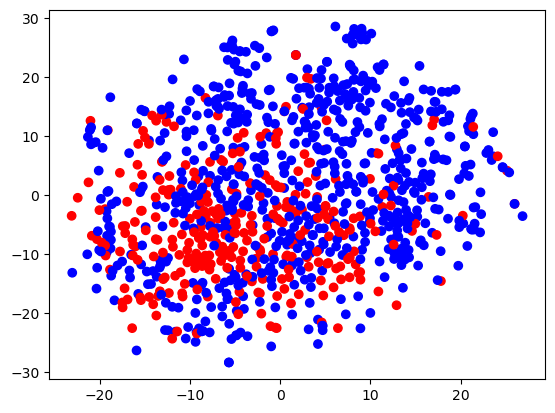

Words used for traning:
['solar', 'pv', 'lead', 'distribut', 'generat', 'search', 'exceed', 'trump', 'stock', 'next', 'new', 'found', 'solar', 'pvs', 'lead', 'world', 'distribut', 'power', 'market', 'consist', 'number', 'percent', 'total', 'distribut', 'power', 'instal', 'last', 'year', 'amount', 'annual', 'instal', 'distribut', 'generat', 'slate', 'increas', 'number', 'gigawatt', 'number', 'rough', 'number', 'gigawatt', 'number', 'number', 'dead', 'dole', 'listeria', 'outbreak', 'search', 'exceed', 'trump', 'stock', 'next', 'eighteen', 'peopl', 'infect', 'outbreak', 'strain', 'listeria', 'report', 'nine', 'state', 'sinc', 'juli', 'number', 'number', 'number', 'ill', 'peopl', 'report', 'state', 'follow', 'connecticut', 'number', 'indiana', 'number', 'number', 'michigan', 'number', 'missouri', 'number', 'new', 'jersey', 'number', 'new', 'york', 'number', 'ohio', 'number', 'pennsylvania', 'number', 'whole', 'perform', 'clinic', 'ill', 'peopl', 'shown', 'high', 'relat', 'genet', 'listeria

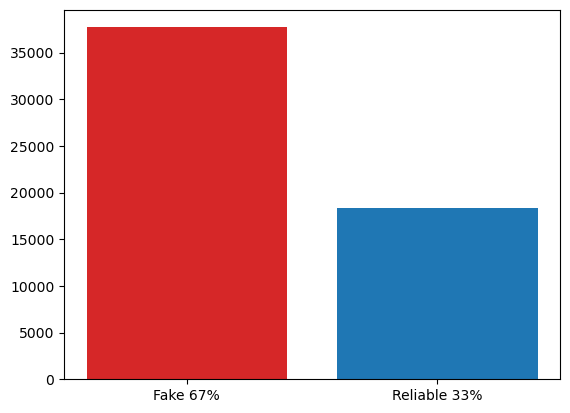

In [51]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from matplotlib.colors import ListedColormap
import seaborn as sns
#from sklearn.decomposition import PCA
'''Plots the balance of the dataset'''
def balanceCheck():
    ones = 0
    zeros = 0
    for num in y_train:
        if num == 1:
            ones += 1
        elif num == 0:
            zeros += 1
    #Percentage
    total = ones + zeros
    percentOnes = round(ones/total * 100)
    percentZeros = round(zeros/total * 100)
    #Plot
    fig, ax = plt.subplots()
    labels = ['Fake ' + str(percentOnes) + '%', 'Reliable ' + str(percentZeros) + '%']
    size = [ones, zeros]
    bar_colors = ['tab:red', 'tab:blue']
    ax.bar(labels, size, label=labels, color=bar_colors)

'''Creates a scatter plot '''
def  scatterPlotOfdata(X, Y):
    tsne = TSNE(n_components=2, random_state=0)
    reduced_vectors = tsne.fit_transform(X)
    scatter_colors = ListedColormap(['red', 'blue'])
    plt.scatter(reduced_vectors[:,0], reduced_vectors[:,1], c=Y, cmap=scatter_colors)
    plt.show()
    return reduced_vectors

print("Scatterplot")
scatterPlotOfdata(X_train[:1000], y_train[:1000])
print("Words used for traning:")
print(lstOfWordsInWv[:100])
print("\nWords not used for training")
print(lstOfWordsNotInWv[:100])

balanceCheck()


t-SNE: For dimensionality reduction
Scatterplot: There doesn't seem to be any clear patterns on where the position of the points are in correlation to wheter it's fake or reliable. 

word2vec-GoogleNews-vectors is from 2016, and doesn't contain words such as blockchain and bitcoin. (reference: https://github.com/mmihaltz/word2vec-GoogleNews-vectors)
